Experiment training model to distiguish if a portrait is a painting or a photo.
Inspired by lesson 1 of [course.fast.ai]

In [9]:
import fastbook
import pathlib

In [ ]:
def dl_ddg_photos_to(path, search_terms):
    for term in search_terms:
        results = fastbook.search_images_ddg(term)
        fastbook.download_images(path, urls=results[:100])

data_path = pathlib.Path('data')
portraits_path = data_path / 'portraits'
paintings_path = portraits_path / 'paintings'
photos_path = portraits_path / 'photos'
for p in (data_path, portraits_path, paintings_path, photos_path):
    if not p.exists():
        p.mkdir()

dl_ddg_photos_to(paintings_path, ['portrait painting -hyperrealistic', 
                                  'classical portrait painting',
                                  'oil on canvas portrait painting',
                                  'watercolor portrait painting'])
dl_ddg_photos_to(photos_path, ['portrait photo -painting',
                               'professional headshot photo',
                               'photograph portrait of a man',
                               'photograph portrait of a woman'])

In [13]:
for pic_path in (paintings_path, photos_path):
    fastbook.resize_images(pic_path, max_size=400, dest=pic_path)

In [14]:
for pic_path in (paintings_path, photos_path):
    bad_images = fastbook.verify_images(fastbook.get_image_files(pic_path))
    bad_images.map(pathlib.Path.unlink)

Had to manually go through the file thumbnails at this point to remove:
* Non-portrait images
* Images with writing, ads, infographics
* Images where painting isn't main focus (living room with painting in it)
* Tiny images too small to tell photo vs painting
* Photo/painting comparisons
* Paintings labelled as photos

/home/tflanigan/mambaforge/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):


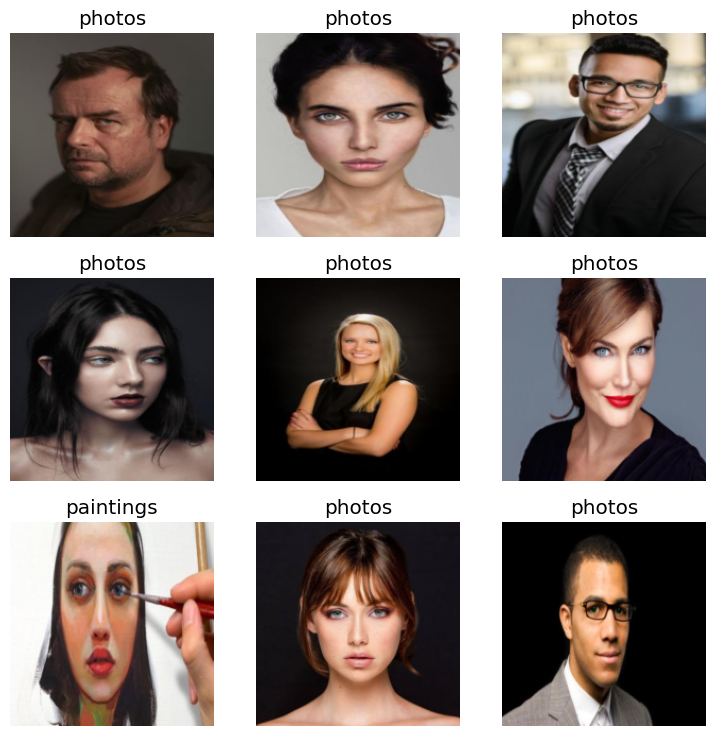

In [16]:
portrait_dls = fastbook.DataBlock(
    blocks=(fastbook.ImageBlock, fastbook.CategoryBlock),
    get_items=fastbook.get_image_files,
    splitter=fastbook.RandomSplitter(valid_pct=0.2, seed=42),
    get_y=fastbook.parent_label,
    item_tfms=[fastbook.Resize(192, method='squish')]
).dataloaders(portraits_path)
portrait_dls.show_batch(max_n=9)

In [20]:
learn = fastbook.cnn_learner(portrait_dls, fastbook.resnet18, metrics=fastbook.error_rate)
learn.fine_tune(3)

/home/tflanigan/mambaforge/lib/python3.10/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/tflanigan/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tflanigan/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /hom

epoch,train_loss,valid_loss,error_rate,time
0,0.791574,0.376167,0.122137,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.375645,0.214068,0.068702,00:10
1,0.238362,0.187259,0.061069,00:10
2,0.176290,0.220150,0.083969,00:10


In [28]:
def is_a_what(image_path):
    answer_map = {"paintings": 'is a painting', "photos": 'is a photo'}
    img = fastbook.PILImage.create(image_path)
    prediction, _, probs = learn.predict(img)
    return answer_map[prediction], probs

for p in (pathlib.Path('painting.jpg'), pathlib.Path('photo.jpg')):
    pred = is_a_what(p)
    print(f"{p} {pred[0]}")
    print(f"Probability: {pred[1][1].item()}")

painting.jpg is a painting
Probability: 0.0007998209912329912


photo.jpg is a photo
Probability: 0.9999357461929321
